# Analyzing IDC data via Bio-Formats and MCMICRO:

[Bio-Formats](https://bio-formats.readthedocs.io/en/stable/index.html) provides the ability to read many different open and proprietary file formats. Whole slide imaging is a common use case, but many other imaging modalities are also supported. Many open source and commercial tools use Bio-Formats to enable interoperable support across imaging domains.

Since it is a Java library, Bio-Formats can be used programmatically to read or convert data; a set of command line tools is also provided which is likely more convenient. Read more about conversion workflows [here](notebooks/advanced_topics/IDC_Recipes_Conversion.ipynb).

[MCMICRO](https://mcmicro.org/) is an end-to-end processing pipeline that transforms multi-channel whole-slide images into single-cell data.

MCMICRO uses Bio-Formats to read input image data; however, multi-image filesets [lacking a separate index file](https://mcmicro.org/troubleshooting/faq.html#q-mcmicro-doesnt-seem-to-recognize-my-file-format-how-do-i-tell-it-what-files-to-look-for), like DICOM, are not well supported. Image data from IDC can therefore be converted to OME-TIFF and used as input to MCMICRO. Read more from the MCMICRO project [here](https://mcmicro.org/tutorial/tutorial.html)

### Install required packages

In [1]:
# IDC supports image download via s5cmd
!pip install s5cmd

# Install bfconvert via bftools
!wget https://downloads.openmicroscopy.org/bio-formats/7.3.0/artifacts/bftools.zip
!unzip bftools.zip

--2024-06-19 15:22:14--  https://downloads.openmicroscopy.org/bio-formats/7.3.0/artifacts/bftools.zip
Resolving downloads.openmicroscopy.org (downloads.openmicroscopy.org)... 134.36.65.239
Connecting to downloads.openmicroscopy.org (downloads.openmicroscopy.org)|134.36.65.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42518871 (41M) [application/zip]
Saving to: ‘bftools.zip’

bftools.zip         100%[===================>]  40.55M  2.42MB/s    in 21s     

2024-06-19 15:22:36 (1.94 MB/s) - ‘bftools.zip’ saved [42518871/42518871]

Archive:  bftools.zip
   creating: bftools/
  inflating: bftools/bf-unconfigured.bat  
  inflating: bftools/bf.bat          
  inflating: bftools/bfconvert.bat   
  inflating: bftools/config.bat      
  inflating: bftools/config.sh       
  inflating: bftools/domainlist.bat  
  inflating: bftools/formatlist.bat  
  inflating: bftools/ijview.bat      
  inflating: bftools/logback.xml     
  inflating: bftools/mkfake.bat      
  inf

### Sample fluorescence data from IDC

In [2]:
# Download sample fluorescence data from IDC

!s5cmd --no-sign-request --endpoint-url https://s3.amazonaws.com cp "s3://idc-open-data/fc078201-b5c5-47d1-92da-3c81dd8cc2c5/*" MCMICRO-example-IDC/DICOM/

cp s3://idc-open-data/fc078201-b5c5-47d1-92da-3c81dd8cc2c5/05b39218-9bac-44dc-8f4f-463802f6ec42.dcm MCMICRO-example-IDC/DICOM/05b39218-9bac-44dc-8f4f-463802f6ec42.dcm
cp s3://idc-open-data/fc078201-b5c5-47d1-92da-3c81dd8cc2c5/a88e5897-96cd-450c-a27e-e7a1916c8efa.dcm MCMICRO-example-IDC/DICOM/a88e5897-96cd-450c-a27e-e7a1916c8efa.dcm
cp s3://idc-open-data/fc078201-b5c5-47d1-92da-3c81dd8cc2c5/923d18e3-0e41-4db8-98ec-faaa466a9970.dcm MCMICRO-example-IDC/DICOM/923d18e3-0e41-4db8-98ec-faaa466a9970.dcm
cp s3://idc-open-data/fc078201-b5c5-47d1-92da-3c81dd8cc2c5/72bd8b32-df42-42a3-b297-35d013e593a3.dcm MCMICRO-example-IDC/DICOM/72bd8b32-df42-42a3-b297-35d013e593a3.dcm
cp s3://idc-open-data/fc078201-b5c5-47d1-92da-3c81dd8cc2c5/8d001790-4b0b-4402-b178-a744368bb5a9.dcm MCMICRO-example-IDC/DICOM/8d001790-4b0b-4402-b178-a744368bb5a9.dcm
cp s3://idc-open-data/fc078201-b5c5-47d1-92da-3c81dd8cc2c5/2ca02489-aa62-43cb-8ab8-6960ebb8fa7b.dcm MCMICRO-example-IDC/DICOM/2ca02489-aa62-43cb-8ab8-6960ebb8fa7b.dc

### Conversion Recipes for fluorescence data

In [3]:
# Use bftools to describe this fluorescence dataset

!./bftools/showinf -nopix -noflat MCMICRO-example-IDC/DICOM/7f154449-615a-41e8-8bdb-96efbe1f11a9.dcm

Checking file format [DICOM]
Initializing reader
DicomReader initializing MCMICRO-example-IDC/DICOM/7f154449-615a-41e8-8bdb-96efbe1f11a9.dcm
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating ima

In [4]:
# Convert fluoresence data using bfconvert - cropping a subset due to its size
# We will ultimately use this OME-TIFF for MCMICRO analysis input
# Note we are writing to the registration folder, as we skip the MICMICRO registration step (multi-channel and multi-cycle data in IDC is already registered)

!./bftools/bfconvert -crop 4000,5000,2000,2000 -series 0 -overwrite MCMICRO-example-IDC/DICOM/7f154449-615a-41e8-8bdb-96efbe1f11a9.dcm MCMICRO-example-IDC/OME-TIFF/registration/fluo-cropped.ome.tiff

MCMICRO-example-IDC/DICOM/7f154449-615a-41e8-8bdb-96efbe1f11a9.dcm
DicomReader initializing MCMICRO-example-IDC/DICOM/7f154449-615a-41e8-8bdb-96efbe1f11a9.dcm
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading tags
Calculating image offsets
Building file list
Populating metadata
Verifying DICOM format
Reading ta

### Run MCMICRO pipeline

In [5]:
#Follow installation instructions from https://mcmicro.org/tutorial/installation.html#installation

!curl -s https://get.nextflow.io | bash

# You must install Docker Enginer following instructions here: https://docs.docker.com/engine/install/
# If the following fails, this indicates an issue with installation.
# TIP: After installation, open/run Docker desktop, which completes some setup steps.

!./nextflow run hello

!docker run hello-world


nloading nextflow dependencies. It may require a few seconds, please wait .. Downloading nextflow dependencies. It may require a few seconds, please wait .. 
      N E X T F L O W
      version 24.04.2 build 5914
      created 29-05-2024 06:19 UTC (02:19 EDT)
      cite doi:10.1038/nbt.3820
      http://nextflow.io


Nextflow installation completed. Please note:
- the executable file `nextflow` has been created in the folder: /Users/erindiel/IDC-Tutorials/notebooks/analysis
- you may complete the installation by moving it to a directory in your $PATH


 N E X T F L O W   ~  version 24.04.2

Launching `https://github.com/nextflow-io/hello` [agitated_wing] DSL2 - revision: 7588c46ffe [master]

[-        ] sayHello -

executor >  local (4)
[7c/5a6760] sayHello (3) | 4 of 4 ✔
Hello world!

Ciao world!

Bonjour world!

Hola world!



Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. T

In [6]:
# Begin with exemplar dataset from MCMICRO to confirm all is runnning as expected

!./nextflow pull labsyspharm/mcmicro

!./nextflow run labsyspharm/mcmicro/exemplar.nf --name exemplar-001 --path exemplar-data

# TIP: users on M1 or newer Mac models having issues with segmentation step may replace segmentation with Ilastik using --segmentation ilastik
# See https://github.com/labsyspharm/mcmicro/issues/353 and share further issues there.

!./nextflow run labsyspharm/mcmicro --in ./exemplar-data/exemplar-001 --segmentation ilastik

Checking labsyspharm/mcmicro ...
 Already-up-to-date - revision: a095a0516f [master]

 N E X T F L O W   ~  version 24.04.2

Launching `https://github.com/labsyspharm/mcmicro` [high_varahamihira] DSL2 - revision: a095a0516f [master]

executor >  local (7)
[32/b983ca] getImages (2)       | 0 of 3
[58/13ac84] getIllumination (3) | 0 of 3
[fe/c7cbbc] getMarkers          | 0 of 1
[-        ] getParams           -

executor >  local (7)
[32/b983ca] getImages (2)       | 0 of 3
[58/13ac84] getIllumination (3) | 0 of 3
[fe/c7cbbc] getMarkers          | 1 of 1 ✔
[-        ] getParams           -

executor >  local (7)
[32/b983ca] getImages (2)       | 0 of 3
[d9/17f455] getIllumination (2) | 1 of 3
[fe/c7cbbc] getMarkers          | 1 of 1 ✔
[-        ] getParams           -

executor >  local (7)
[cc/dae368] getImages (3)       | 1 of 3
[d9/17f455] getIllumination (2) | 1 of 3
[fe/c7cbbc] getMarkers          | 1 of 1 ✔
[-        ] getParams           -

executor >  local (7)
[32/b983ca] getIma

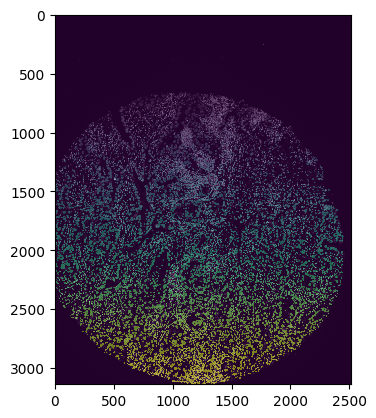

In [7]:
# Visualize the results

# if needed, install the following:
# !pip install tifffile
# !pip install matplotlib

from tifffile import imread
import matplotlib.pyplot as plt

image = imread('exemplar-data/exemplar-001/registration/exemplar-001.ome.tif')
# cells = imread('exemplar-data/exemplar-001/segmentation/ilastik-exemplar-001/cell.ome.tif')
nuclei = imread('exemplar-data/exemplar-001/segmentation/ilastik-exemplar-001/nuclei.ome.tif')

plt.imshow(image[0, :, :], 'gray', interpolation='none')
plt.imshow(nuclei, interpolation='none', alpha=0.5)

In [8]:
# Next analyze the IDC data - the cropped OME-TIFF will be quicker to complete
# MCMICRO params.yml and markers.csv files are included in this example
# Note the excitation and emission wavelengths in markers.csv are approximated based on available metadata

!./nextflow run labsyspharm/mcmicro --in ./MCMICRO-example-IDC/OME-TIFF/

# Ilastik is used in this example, as specified in params.yml
# Providing your own Ilastik model and tuning parameters will improve segmentation results.
# See documentation for more information: https://mcmicro.org/parameters/other.html#ilastik


 N E X T F L O W   ~  version 24.04.2

Launching `https://github.com/labsyspharm/mcmicro` [silly_saha] DSL2 - revision: a095a0516f [master]

[-        ] illumination                -
[-        ] registration:ashlar         -
[-        ] background:backsub          -
[-        ] dearray:coreograph          -
[-        ] dearray:roadie:runTask      -
[-        ] segmentation:roadie:runTask -
[-        ] segmentation:worker         | 0 of 1
[-        ] segmentation:s3seg          -
[-        ] quantification:mcquant      -
[-        ] downstream:worker           -
[-        ] viz:autominerva             -

executor >  local (1)
[-        ] illumination                   -
[-        ] registration:ashlar            -
[-        ] background:backsub             -
[-        ] dearray:coreograph             -
[-        ] dearray:roadie:runTask         -
[-        ] segmentation:roadie:runTask    -
[bb/5aba12] seg…ntation:worker (ilastik-1) | 0 of 1
[-        ] segmentation:s3seg             -

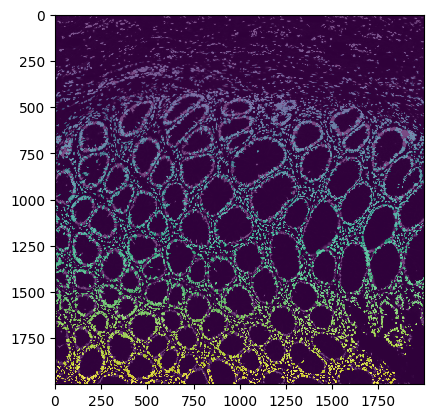

In [9]:
# Visualize the results

# if needed, install the following:
# !pip install tifffile
# !pip install matplotlib

from tifffile import imread
import matplotlib.pyplot as plt

image = imread('MCMICRO-example-IDC/OME-TIFF/registration/fluo-cropped.ome.tiff')
# cells = imread('MCMICRO-example-IDC/OME-TIFF/segmentation/ilastik-fluo-cropped/cell.ome.tif')
nuclei = imread('MCMICRO-example-IDC/OME-TIFF/segmentation/ilastik-fluo-cropped/nuclei.ome.tif')

plt.imshow(image[0, :, :], 'gray', interpolation='none')
plt.imshow(nuclei, interpolation='none', alpha=0.7)

Check out the [QuPath notebook](notebooks/advanced_topics/qupath/QuPath_import.ipynb) to see other analysis options for IDC data.